In [1]:
import cv2
import pillow_heif

from PIL import Image
from PIL.ExifTags import TAGS

In [2]:
import os
from collections import Counter
from typing import Tuple, List, Optional

import pandas as pd
import numpy as np

from tqdm.auto import tqdm
tqdm.pandas()

C:\Users\_v010ch_\Anaconda3\envs\uly22\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#import seaborn as sns

In [4]:
#import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

In [5]:
%matplotlib inline

In [6]:
#!pip list

In [7]:
DIR_DATA = os.path.join(os.getcwd(), 'data')
DIR_DATA_TRAIN = os.path.join(DIR_DATA, 'train')
DIR_DATA_TEST  = os.path.join(DIR_DATA, 'test')

In [8]:
def open_img(inp_path: str) -> np.ndarray:
    
    if inp_path.endswith('.jpg'):
        ret_img = cv2.imread(inp_path)
    else:
        if pillow_heif.is_supported(inp_path):
            heif_file = pillow_heif.open_heif(inp_path, convert_hdr_to_8bit=False)
            #print("image mode:", heif_file.mode)
            #print("image data length:", len(heif_file.data))
            #print("image data stride:", heif_file.stride)
            if heif_file.has_alpha:
                heif_file.convert_to("BGRA;16")
            else:
                heif_file.convert_to("BGR;16")  # convert 10 bit image to RGB 16 bit.
            #print("image mode:", heif_file.mode)
            ret_img = np.asarray(heif_file)
    
    return ret_img

In [9]:
def plot_corrc(inp_df: pd.DataFrame, inp_cols: List[str], targ_cols: Optional[List[int]] = ['distance']):
    f, ax = plt.subplots(1, 2, figsize=(24, 8))
    sns.heatmap(inp_df[inp_cols + targ_cols].corr(),
    #sns.heatmap(inp_df.query('c2 == 0')[inp_cols + targ_cols].corr(), \n",
                annot = True, cmap= 'coolwarm', linewidths=3, linecolor='black', ax = ax[0])
    sns.heatmap(inp_df[inp_cols + targ_cols].corr(method = 'spearman'),
    #sns.heatmap(inp_df.query('c2 == 1')[inp_cols + targ_cols].corr(), \n",
                annot = True, cmap= 'coolwarm', linewidths=3, linecolor='black', ax = ax[1])
#    sns.heatmap(inp_df.query('c2 == 0')[inp_cols + targ_cols].corr(method = 'spearman'), \n",
#                annot = True, cmap= 'coolwarm', linewidths=3, linecolor='black', ax = ax[1, 0])\n",
#    sns.heatmap(inp_df.query('c2 == 1')[inp_cols + targ_cols].corr(method = 'spearman'), \n",
#                annot = True, cmap= 'coolwarm', linewidths=3, linecolor='black', ax = ax[1, 1])\n",
    if 'distrib_brdr' in inp_df.columns:
        sns.pairplot(inp_df[inp_cols + targ_cols + ['distrib_brdr']], height = 16,
                     hue = 'distrib_brdr', #palette = {\"A\": \"C0\", \"B\": \"C1\"}\n",
                     #markers = ['x', 'o']\n",
                    )
    else:
        sns.pairplot(inp_df[inp_cols + targ_cols], height = 16,
                    )

## Загрузка данных

In [10]:
train_list = os.listdir(DIR_DATA_TRAIN)
test_list  = os.listdir(DIR_DATA_TEST)

train_heic = [el for el in train_list if el.endswith('.heic')]
test_heic  = [el for el in test_list  if el.endswith('.heic')]

train_jpg = [el for el in train_list if el.endswith('.jpg')]
test_jpg  = [el for el in test_list if el.endswith('.jpg')]

fnames_train = set([el.split('.')[0] for el in train_list])
fnames_test  = set([el.split('.')[0] for el in test_list])

In [11]:
#print(Counter([el.split('.')[1] for el in train_list]))
#print(Counter([el.split('.')[1] for el in test_list]))

### Загружаем данные

(train_upd загружается только после выполнения 2step_make_features)

In [12]:
#train_df = pd.read_csv(os.path.join(DIR_DATA, 'train.csv'), delimiter = ';')
train_df = pd.read_csv(os.path.join(DIR_DATA, 'train_upd.csv'))
test_df  = pd.read_csv(os.path.join(DIR_DATA, 'test_upd.csv'))
train_df.shape, test_df.shape

((530, 16), (517, 15))

In [13]:
train_df.head()

,image_name,distance,x_min,y_min,x_max,y_max,conf,class,h,w,log_x_min,log_y_min,log_x_max,log_y_max,log_h,log_w
0,img_1596.jpg,4.88,1661.424072,1172.543701,2280.588135,1717.848145,0.860831,2.0,545.304443,619.164062,7.415430,7.066931,7.732189,7.448828,6.301344,6.428370
1,img_1600.jpg,1.54,1125.089722,1185.073486,3012.445312,2716.680420,0.853032,2.0,1531.606934,1887.355591,7.025618,7.077560,8.010507,7.907166,7.334073,7.542932
2,img_1601.jpg,3.68,1573.182739,1192.814087,2434.594727,2019.641357,0.639996,2.0,826.827271,861.411987,7.360856,7.084071,7.797536,7.610675,6.717596,6.758573
3,img_1603.jpg,2.22,2602.999512,1277.598389,3310.421875,1849.868042,0.779553,2.0,572.269653,707.422363,7.864420,7.152737,8.104831,7.522870,6.349610,6.561628
4,img_1605.jpg,3.73,1612.041016,1101.496704,2481.691650,1924.515015,0.764157,2.0,823.018311,869.650635,7.385256,7.004425,7.816696,7.562429,6.712978,6.768092


In [14]:
train_df.groupby('image_name').agg('size').value_counts()

1    530
dtype: int64

Посмотрим на размеры

Посмотрим на мин и макс

In [15]:
train_df.distance.nlargest(5)

91     9.38
260    9.06
80     8.80
90     8.78
368    8.74
Name: distance, dtype: float64

In [16]:
train_df.distance.nsmallest(5)

480    0.85
124    1.06
479    1.09
19     1.12
199    1.16
Name: distance, dtype: float64

In [17]:
print('min ', train_df.distance[train_df.distance.argmin()], '  ', train_df.image_name[train_df.distance.argmin()])
print('max ', train_df.distance[train_df.distance.argmax()], '  ', train_df.image_name[train_df.distance.argmax()])

min  0.85    img_2858.jpg
max  9.38    img_2724.heic


In [18]:
#img = open_img(os.path.join(DIR_DATA_TRAIN, train_df.image_name[train_df.distance.argmin()]))
img = open_img(os.path.join(DIR_DATA_TRAIN, train_df.image_name[train_df.distance.argmax()]))
#img = cv2.resize(img, [504*4, 504*3])
img = cv2.resize(img, [252*4, 252*3])
cv2.imshow('random', img)
cv2.waitKey(0)
cv2.destroyAllWindows() 

In [19]:
train_df['ext'] = train_df.image_name.apply(lambda x: x.split('.')[1])

<AxesSubplot:>

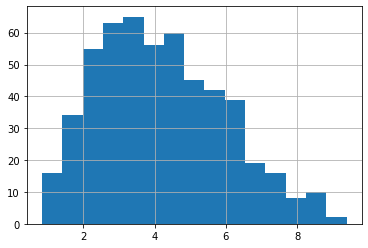

In [20]:
train_df.distance.hist(bins = 15)

In [21]:
# 520 x 112
# 245 x 160
# 290 х 170

Посмотрим пересечение датасетов

In [22]:
tmp = list(fnames_train.intersection(fnames_test))
len(tmp)

44

Смазанные фото

In [23]:
motion_blur_train = ['img_2709.heic', 'img_2733.heic', 'img_2734.heic']    # 'img_2734.heic' возможно рабочий 
motion_blur_test  = ['img_2674.heic']

In [24]:
img = open_img(os.path.join(DIR_DATA_TRAIN, 'img_2745.heic'))
#img = open_img(os.path.join(DIR_DATA_TEST, motion_blur_test[0]))
img = cv2.resize(img, [252*4, 252*3])
               
cv2.imshow('motion blur', img)
cv2.waitKey(0)
cv2.destroyAllWindows() 

In [25]:
train_df.columns

Index(['image_name', 'distance', 'x_min', 'y_min', 'x_max', 'y_max', 'conf',
       'class', 'h', 'w', 'log_x_min', 'log_y_min', 'log_x_max', 'log_y_max',
       'log_h', 'log_w', 'ext'],
      dtype='object')

In [26]:
#train_df['exp_w'] = train_df.w.apply(lambda x: np.exp(x))
train_df['log_w'] = train_df.w.apply(lambda x: np.log(x))

Посмотрим на корреляцию с признаками из train_upd

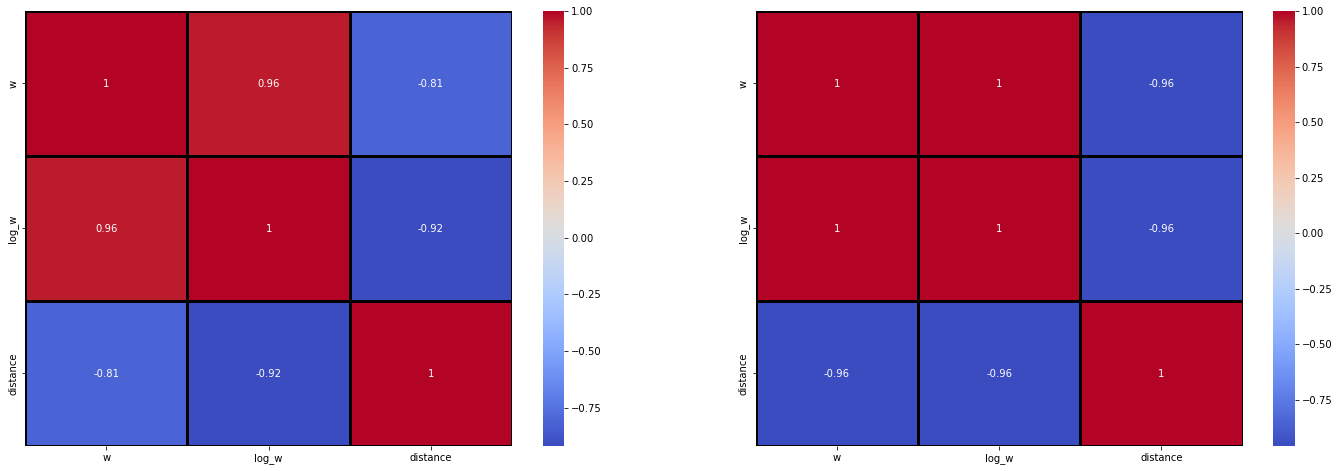

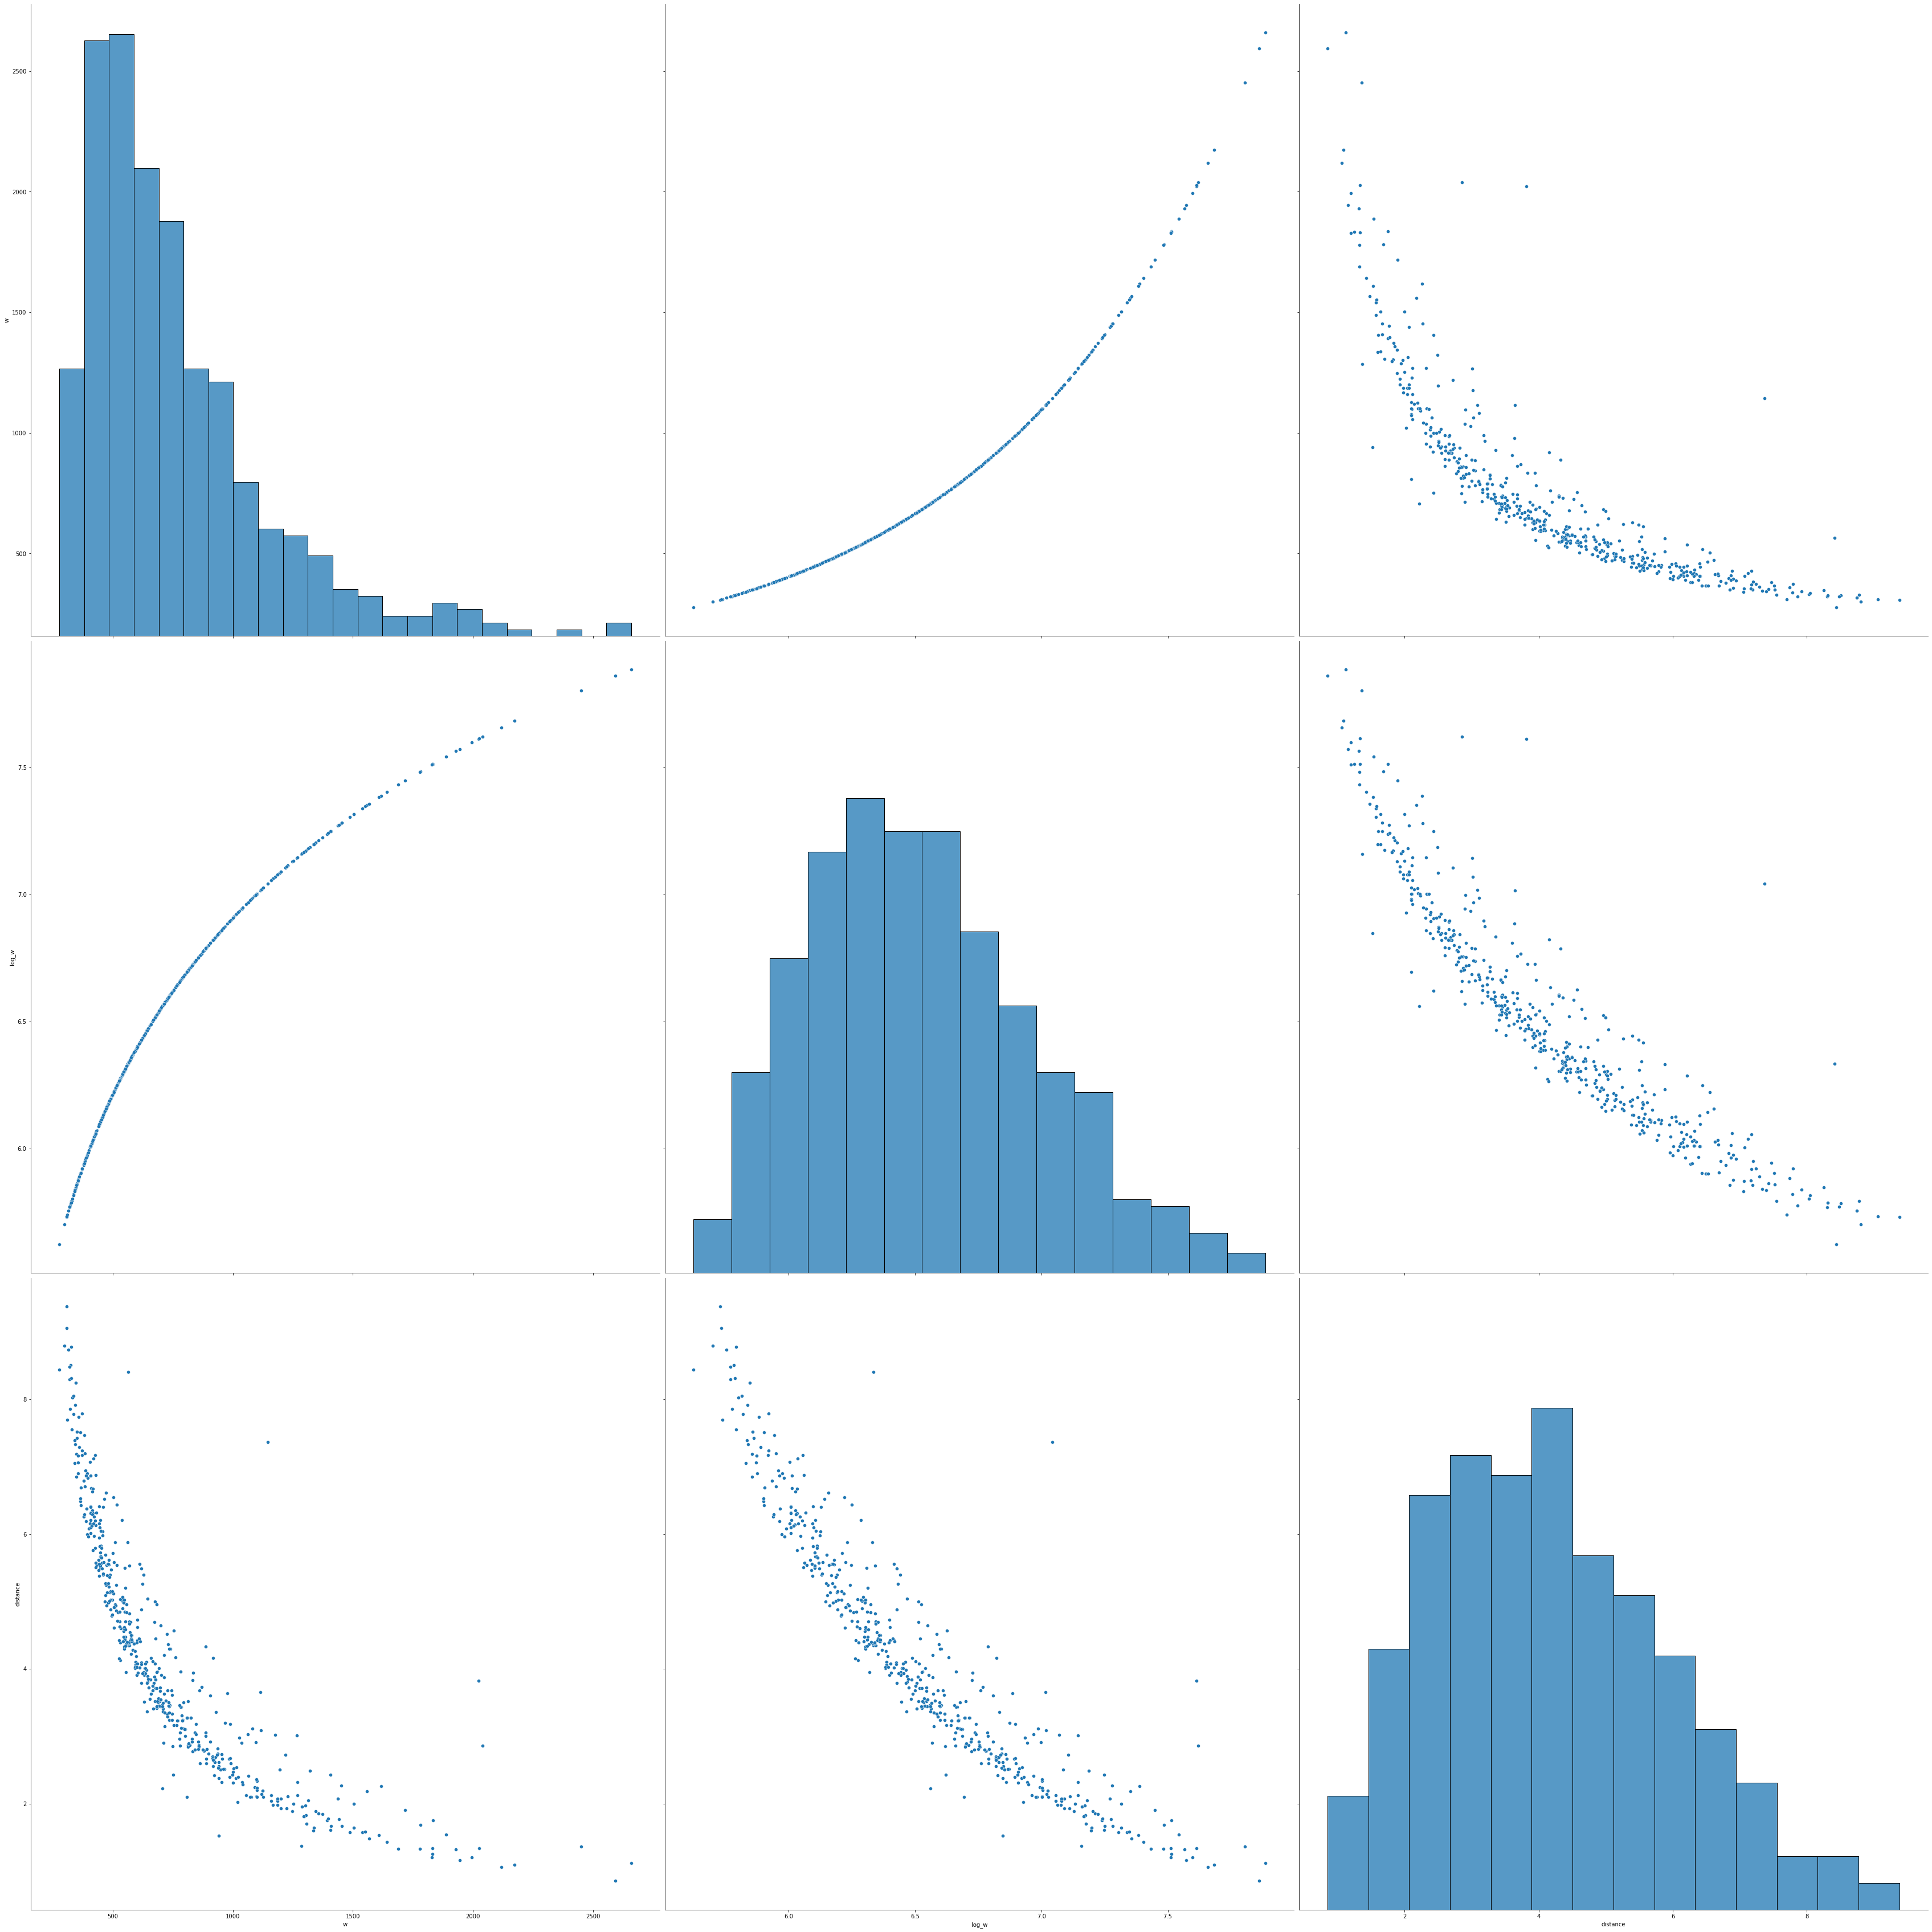

In [27]:
#plot_corrc(train_df, ['x_min', 'y_min', 'x_max', 'y_max', 'h', 'w']) #'conf', 
plot_corrc(train_df, ['w', 'log_w'])

In [29]:
train_df.sort_values('w').head(5)

,image_name,distance,x_min,y_min,x_max,y_max,conf,class,h,w,log_x_min,log_y_min,log_x_max,log_y_max,log_h,log_w,ext
92,img_2726.heic,8.44,1835.837769,1418.255981,2112.787109,1653.007446,0.897338,2.0,234.751465,276.949341,7.515256,7.257183,7.655763,7.410352,5.458527,5.623835,heic
80,img_2696.heic,8.80,1824.759521,1369.581787,2123.758057,1620.478638,0.884633,2.0,250.896851,298.998535,7.509203,7.222261,7.660942,7.390477,5.525042,5.700439,heic
91,img_2724.heic,9.38,1784.518921,1340.706787,2092.518066,1598.900635,0.910434,2.0,258.193848,307.999146,7.486904,7.200952,7.646123,7.377072,5.553711,5.730097,heic
260,img_2333.jpg,9.06,1701.352539,1323.466309,2010.536987,1619.377563,0.916251,2.0,295.911255,309.184448,7.439179,7.188010,7.606157,7.389797,5.690060,5.733938,jpg
228,img_2277.jpg,7.70,1731.605591,1231.743652,2042.223145,1532.557739,0.920678,2.0,300.814087,310.617554,7.456804,7.116186,7.621794,7.334693,5.706492,5.738562,jpg


In [30]:
test_df.sort_values('w').head(5)

,image_name,x_min,y_min,x_max,y_max,conf,class,h,w,log_x_min,log_y_min,log_x_max,log_y_max,log_h,log_w
24,img_1880.jpg,1753.013184,1384.815918,2008.287354,1612.727905,0.729800,2.0,227.911987,255.274170,7.469091,7.233322,7.605038,7.385682,5.428960,5.542338
351,img_1905.jpg,1982.458130,1276.309082,2252.887939,1504.189575,0.742766,2.0,227.880493,270.429810,7.592093,7.151728,7.719968,7.316010,5.428821,5.600013
147,img_1879.jpg,1713.180664,1377.668823,1987.931152,1620.057007,0.695013,2.0,242.388184,274.750488,7.446107,7.228148,7.594850,7.390217,5.490541,5.615863
452,img_2725.heic,1815.390503,1399.077637,2099.392578,1641.808838,0.886873,2.0,242.731201,284.002075,7.504056,7.243568,7.649403,7.403554,5.491955,5.648982
218,img_2693.jpg,1740.487061,1383.140625,2042.825439,1647.762939,0.830807,2.0,264.622314,302.338379,7.461920,7.232112,7.622089,7.407174,5.578304,5.711547


In [32]:
#el = 92 # 394, 313, 314
#name, x_min, y_min, x_max, y_max, dist = train_df.loc[el, ['image_name', 'x_min', 'y_min', 'x_max', 'y_max', 'distance']].values

el = 122 # 143, 122, 32, 406
name, x_min, y_min, x_max, y_max = test_df.loc[el, ['image_name', 'x_min', 'y_min', 'x_max', 'y_max']].values

img = open_img(os.path.join(DIR_DATA_TEST, name))

cv2.rectangle(img, 
              (int(x_min), int(y_min)), 
              (int(x_max), int(y_max)),
              (255, 0, 0), 
              6,
              #cv2.FILLED
             )


img = cv2.resize(img, [252*4, 252*3])

cv2.imshow('bir error', img)
cv2.waitKey(0)
cv2.destroyAllWindows()

Проверим метеданные фотографий

In [23]:
# open the image
image = Image.open(os.path.join(DIR_DATA_TRAIN, train_jpg[0]))
  
# extracting the exif metadata
exifdata = image.getexif()
  
# looping through all the tags present in exifdata
for tagid in exifdata:
      
    # getting the tag name instead of tag id
    tagname = TAGS.get(tagid, tagid)
  
    # passing the tagid to get its respective value
    value = exifdata.get(tagid)
    
    # printing the final result
    print(f"{tagname:25}: {value}")

GPSInfo                  : 2192
ResolutionUnit           : 2
ExifOffset               : 226
Make                     : Apple
Model                    : iPhone 11
Software                 : 15.5
Orientation              : 1
DateTime                 : 2022:07:07 11:02:48
YCbCrPositioning         : 1
XResolution              : 72.0
YResolution              : 72.0
HostComputer             : iPhone 11


In [24]:
colors = {0: (0, 0, 255), 1: (255, 0, 0), 2: (0, 255, 0), }

In [25]:
import torch

model = torch.hub.load('ultralytics/yolov5', 'yolov5s')
model.classes = [0, 2]  # person and car

_ = model.cpu()

Using cache found in C:\Users\_v010ch_/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2022-8-3 Python-3.10.4 torch-1.12.0 CUDA:0 (GeForce GTX 1050 Ti, 4096MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


In [26]:
# motion blur img_2733.heic, img_2734.heic
# nearest img_2858.jpg
# several cars img_2896.jpg, img_2885.jpg, !! img_2674.jpg, img_2660.jpg
# part closed img_2723.jpg
# left first img_2694.jpg
# car by side img_2418.jpg, 
# construction on the roof img_1832.jpg
# double car img_1621.jpg


# !!!TEST with strange number

# 'x_min', 'y_min', 'x_max', 'y_max', 'conf', 'class'

In [27]:
#img = open_img(os.path.join(DIR_DATA_TRAIN, 'img_2733.heic'))
img = open_img(os.path.join(DIR_DATA_TRAIN, 'img_2674.jpg'))
#results = model(np.array(img))
results = model(img)

In [28]:
colors[results.xyxy[0][0][-1].int().item()]

(0, 255, 0)

In [29]:
def get_car_center(inp_tensor: torch.Tensor) -> Tuple[int, int]:
    
    #car_cntr = (int((inp_tensor.xyxy[0][el][2].int().item() - inp_tensor.xyxy[0][el][0].int().item())/2 + inp_tensor.xyxy[0][el][0].int().item()),
    #            int((inp_tensor.xyxy[0][el][3].int().item() - inp_tensor.xyxy[0][el][1].int().item())/2 + inp_tensor.xyxy[0][el][1].int().item())
    #    )

    car_cntr = (int((inp_tensor[2].int().item() - inp_tensor[0].int().item())/2 + inp_tensor[0].int().item()),
                int((inp_tensor[3].int().item() - inp_tensor[1].int().item())/2 + inp_tensor[1].int().item())
        )
    
    return car_cntr

In [30]:
def get_center_dist(inp_center: Tuple[int, int], inp_point: Tuple[int, int]) -> float:
    
    return np.sqrt((inp_center[0] - inp_point[0])**2 + \
                   (inp_center[1] - inp_point[1])**2)

In [31]:
def determine_targ_car(inp_results, inp_img_cntr) -> int:
    
    min = 1000000

    for el in range(inp_results.xyxy[0].shape[0]):
        car_cntr = get_car_center(inp_results.xyxy[0][el])
        cur_dist = get_center_dist(inp_img_cntr, car_cntr)
        if cur_dist < min:
            min = cur_dist
            min_idx = el

    #print(min_idx)
    return min_idx

In [32]:
img_cntr = (int(img.shape[1]/2), int(img.shape[0]/2))
target_goal = determine_targ_car(results, img_cntr)

In [33]:
cv2.circle(img, img_cntr, 10, (0, 0, 255), 20)
cv2.rectangle(img, 
              (results.xyxy[0][target_goal][0].int().item(), results.xyxy[0][target_goal][1].int().item()), 
             (results.xyxy[0][target_goal][2].int().item(), results.xyxy[0][target_goal][3].int().item()), 
             colors[results.xyxy[0][target_goal][-1].int().item()], 2)
#image = cv.circle(image, centerOfCircle, radius, color, thickness)
car_cntr = get_car_center(results.xyxy[0][target_goal])
_ = cv2.circle(img, car_cntr, 10, (255, 0, 0), 20)

In [34]:
img = cv2.resize(img, [252*4, 252*3])
               
cv2.imshow('motion blur', img)
cv2.waitKey(0)
cv2.destroyAllWindows() 

In [44]:
#for idx, el in enumerate(train_list[:10]):
for idx, el in enumerate(train_list[:10]):
    img = open_img(os.path.join(DIR_DATA_TRAIN, el))
    
    results = model(img)
    
    if results.xyxy[0].shape != torch.Size([0, 6]):
        #print(results.xyxy[0].shape)
        for obj in range(results.xyxy[0].shape[0]):
            cv2.rectangle(img, 
                          (results.xyxy[0][obj][0].int().item(), results.xyxy[0][obj][1].int().item()), 
                          (results.xyxy[0][obj][2].int().item(), results.xyxy[0][obj][3].int().item()), 
                          colors[results.xyxy[0][obj][-1].int().item()], 
                          6,
                          #cv2.FILLED
                         )
            #_ = cv2.circle(img, car_cntr, 10, (255, 0, 0), 20)
            #print(obj)
        img_cntr = (int(img.shape[1]/2), int(img.shape[0]/2))
        target_goal = determine_targ_car(results, img_cntr)
        #print(target_goal)
        sub_img = img[results.xyxy[0][target_goal][0].int().item() : results.xyxy[0][target_goal][1].int().item(), 
                      results.xyxy[0][target_goal][2].int().item() : results.xyxy[0][target_goal][3].int().item()
                     ]
        white_rect = np.ones(sub_img.shape, dtype=np.uint8) * 255
        res = cv2.addWeighted(sub_img, 0.5, white_rect, 0.5, 1.0)
        
        img[results.xyxy[0][target_goal][0].int().item() : results.xyxy[0][target_goal][1].int().item(), 
            results.xyxy[0][target_goal][2].int().item() : results.xyxy[0][target_goal][3].int().item()
           ] = sub_img
        
        
    cv2.circle(img, img_cntr, 10, (0, 0, 255), 20)
    
    img = cv2.resize(img, [252*4, 252*3])
    #img = cv2.resize(img, [504*4, 504*3])    
               
    cv2.imshow(f'{idx} {el}', img)
    cv2.waitKey(0)
    cv2.destroyAllWindows() 
    
    #break

In [50]:
img.shape

(756, 1008, 3)

In [48]:

sub_img = img[results.xyxy[0][target_goal][0].int().item() : results.xyxy[0][target_goal][1].int().item(), 
              results.xyxy[0][target_goal][2].int().item() : results.xyxy[0][target_goal][3].int().item()
             ]
sub_img

array([], shape=(0, 0, 3), dtype=uint8)

In [45]:
    sub_img = cv2.resize(sub_img, [252*4, 252*3])
    #img = cv2.resize(img, [504*4, 504*3])    
               
    cv2.imshow(f'{idx} {el}', sub_img)
    cv2.waitKey(0)
    cv2.destroyAllWindows() 

error: OpenCV(4.6.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'


In [52]:
    cv2.imshow(f'{idx} {el}', img[results.xyxy[0][target_goal][0].int().item() : results.xyxy[0][target_goal][1].int().item(), 
              results.xyxy[0][target_goal][2].int().item() : results.xyxy[0][target_goal][3].int().item()
             ])
    cv2.waitKey(0)
    cv2.destroyAllWindows() 

error: OpenCV(4.6.0) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window.cpp:967: error: (-215:Assertion failed) size.width>0 && size.height>0 in function 'cv::imshow'


In [53]:
results.xyxy[0][target_goal][0].int().item(), results.xyxy[0][target_goal][1].int().item(),  results.xyxy[0][target_goal][2].int().item(), results.xyxy[0][target_goal][3].int().item()

(1694, 1176, 2286, 1768)

In [54]:
'x_min', 'y_min', 'x_max', 'y_max', 'conf',

('x_min', 'y_min', 'x_max', 'y_max', 'conf')